<a href="https://colab.research.google.com/github/Mtlukasik/PyroNotebooks/blob/main/BasicProbModelsPyro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q --upgrade pyro-ppl torch graphviz
import pyro
import torch
import pyro.distributions as dist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.5/732.5 kB 12.1 MB/s eta 0:00:00


# 1. **Pyro’s models** (http://pyro.ai/examples/intro_part_i.html) :


* In Pyro, a probabilistic model is defined as a **stochastic function** (i.e. every time it is run, it returns a new sample).

* Each random variable is associated with a **primitive stochastic function** using the construct ``pyro.sample(...)``.


### 1.1 A Temperature Model



As initial running example, we consider the problem of **modelling the temperature**. We first start with a simple model, where temperture is modeled using a random Normal variable.

tensor(13.6987)
tensor(14.8758)


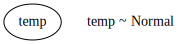

In [2]:
def model():
    temp = pyro.sample('temp', dist.Normal(15.0, 2.0))
    return temp

print(model())
print(model())
# Visualize the model
pyro.render_model(model, render_distributions=True)

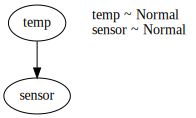

In [3]:
def model():
    temp = pyro.sample('temp', dist.Normal(15.0, 2.0))
    sensor = pyro.sample('sensor', dist.Normal(temp, 1.0))
    return (temp, sensor)

# Visualize the model
pyro.render_model(model, render_distributions=True)


### 1.2 A Gaussian Mixture Model



As initial running example, we consider the problem of **modelling clusters**. We first start with a simple model, where temperture is modeled using a random Normal variable.

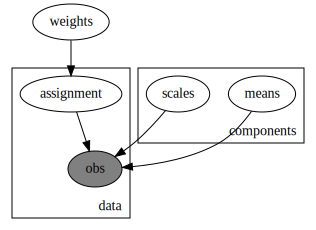

In [5]:
def gmm_model(data):
    # Prior over the number of clusters
    K = 2

    # Prior over the mixing proportions
    weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))

    with pyro.plate('components', K):
        # Priors for the component means and standard deviations
        means = pyro.sample('means', dist.Normal(torch.zeros(K), 5.0 * torch.ones(K)))
        scales = pyro.sample('scales', dist.LogNormal(torch.zeros(K), 0.5 * torch.ones(K)))

    with pyro.plate('data', len(data)):
        # Mixture assignment for each data point
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        # Condition on the observed data
        pyro.sample('obs', dist.Normal(means[assignment], scales[assignment]), obs=data)
# Generate some data
true_weights = torch.tensor([0.3, 0.7])
true_means = torch.tensor([-1.0, 1.0])
true_scales = torch.tensor([0.5, 0.5])

n_data = 500
assignments = dist.Categorical(true_weights).sample((n_data,))
gmm_data = dist.Normal(true_means[assignments], true_scales[assignments]).sample()


# Now you can call your model with this data
pyro.render_model(gmm_model, model_args=(gmm_data,))


### 1.3 Hidden Markov Model

A Hidden Markov Model (HMM) is a statistical Markov model in which the system being modeled is assumed to be a Markov process with unobserved (hidden) states. HMMs are widely used in temporal pattern recognition such as speech, handwriting, gesture recognition, part-of-speech tagging, musical score following, partial discharges and bioinformatics.

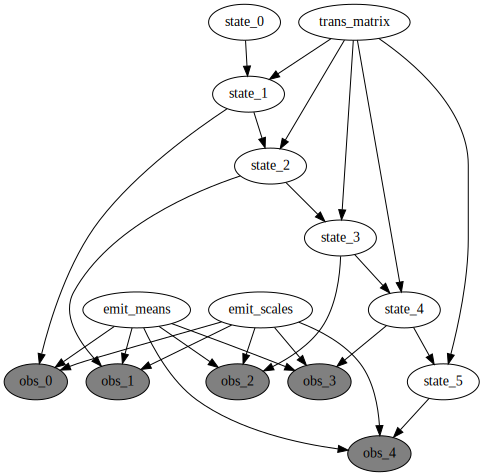

In [15]:

def hmm_model(data):
    # Number of hidden states
    K = 2

    # Transition matrix
    trans_matrix = pyro.sample('trans_matrix', dist.Dirichlet(0.5 * torch.ones(K, K)))

    # Emission means and scales
    emit_means = pyro.sample('emit_means', dist.Normal(torch.zeros(K), 5.0 * torch.ones(K)))
    emit_scales = pyro.sample('emit_scales', dist.LogNormal(torch.zeros(K), 0.5 * torch.ones(K)))

    # Initial state
    state = pyro.sample('state_0', dist.Categorical(torch.ones(K) / K))

    for t in range(len(data)):
        state = pyro.sample(f'state_{t+1}', dist.Categorical(trans_matrix[state]), infer={"enumerate": "parallel"})
        pyro.sample(f'obs_{t}', dist.Normal(emit_means[state], emit_scales[state]), obs=data[t])


# Generate some data
true_trans_matrix = torch.tensor([[0.8, 0.2], [0.2, 0.8]])
true_emit_means = torch.tensor([-1.0, 1.0])
true_emit_scales = torch.tensor([0.5, 0.5])

n_data = 5
state = dist.Categorical(torch.ones(2) / 2).sample()
data = []
for _ in range(n_data):
    state = dist.Categorical(true_trans_matrix[state]).sample()
    data.append(dist.Normal(true_emit_means[state], true_emit_scales[state]).sample())

hmm_data = torch.stack(data)

# Now you can call your model with this data
pyro.render_model(hmm_model, model_args=(hmm_data,))


### 1.5 Factor Analysis and Principal component analysis




### 1.6 Chinease restaurant process & Dirichlet Mixture of Wishards
